# Fall Detection Analysis

This notebook analyzes sensor data from the motion monitoring app to tune fall detection thresholds.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
import numpy as np
from scipy.fft import fft, fftfreq

In [3]:
df = pd.read_csv('sensor_data.csv', header=None, names=['server_timestamp_utc', 'client_timestamp_ms', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'])
df.head()

,server_timestamp_utc,client_timestamp_ms,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,server_timestamp_utc,client_timestamp_ms,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
1,2025-11-09T10:34:53.110Z,1762684493397,0,0,0,0,0,0
2,2025-11-09T10:34:53.350Z,1762684493653,0,0,0,0,0,0
3,2025-11-09T10:34:53.525Z,1762684493827,0,0,0,0,0,0
4,2025-11-09T10:34:54.163Z,1762684494460,0,0,0,0,0,0


In [4]:
df.dropna(inplace=True)

In [6]:
# Ensure pandas is available (only import if not already present)
try:
	pd
except NameError:
	import pandas as pd

# Ensure df is defined (load CSV if this cell is executed before the read cell)
try:
	df
except NameError:
	df = pd.read_csv('sensor_data.csv', header=None, names=['server_timestamp_utc', 'client_timestamp_ms', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'])

# Convert numeric columns to float
numeric_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'client_timestamp_ms']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# If acc_x/acc_y/acc_z are missing, try to infer them from the last three numeric columns
if not {'acc_x', 'acc_y', 'acc_z'}.issubset(df.columns):
	numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
	if len(numeric_cols) >= 3:
		acc_cols = numeric_cols[-3:]
		df = df.copy()
		df.rename(columns={acc_cols[0]: 'acc_x', acc_cols[1]: 'acc_y', acc_cols[2]: 'acc_z'}, inplace=True)
	else:
		raise KeyError("Could not find acc_x, acc_y, acc_z in df and unable to infer from numeric columns.")

# Compute acceleration magnitude
df['acc_mag'] = (df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)**0.5

In [9]:
# Calculate sampling rate
# Ensure we have a proper timestamp column named 'server_timestamp_utc'.
if 'server_timestamp_utc' not in df.columns:
	# Try to infer a timestamp-like column by attempting conversion
	inferred = None
	for col in df.columns:
		try:
			# try converting the column to datetimes (raise on failure)
			pd.to_datetime(df[col], errors='raise')
			inferred = col
			break
		except Exception:
			continue
	if inferred is None:
		raise KeyError("Could not find 'server_timestamp_utc' column and unable to infer it from existing columns.")
	# rename the inferred column
	df = df.rename(columns={inferred: 'server_timestamp_utc'})

# Convert to datetime (coerce invalids to NaT), sort and drop invalid timestamps
df['server_timestamp_utc'] = pd.to_datetime(df['server_timestamp_utc'], errors='coerce')
df = df.sort_values('server_timestamp_utc')
df = df.dropna(subset=['server_timestamp_utc'])

# Need at least two timestamps to compute sampling rate
if len(df) < 2:
	raise ValueError("Not enough timestamped rows to compute sampling rate.")

dt = df['server_timestamp_utc'].diff().dt.total_seconds().dropna().mean()
if dt <= 0 or np.isnan(dt):
	raise ValueError(f"Computed an invalid mean dt: {dt}")

fs = 1 / dt  # Sampling frequency in Hz
print(f"Sampling frequency: {fs:.2f} Hz")

Sampling frequency: 0.24 Hz


Dominant frequency: 0.00 Hz
Cadence: 0.05 steps per minute


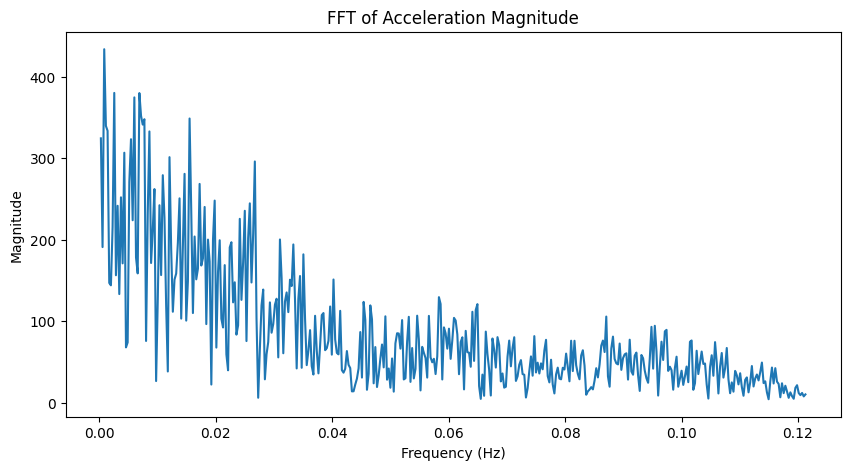

In [10]:
# Perform FFT on acc_mag
acc_mag = df['acc_mag'].values
N = len(acc_mag)
yf = fft(acc_mag)
xf = fftfreq(N, 1/fs)

# Get positive frequencies
positive_freqs = xf[xf > 0]
magnitudes = np.abs(yf[xf > 0])

# Find dominant frequency
dominant_idx = np.argmax(magnitudes)
dominant_freq = positive_freqs[dominant_idx]
cadence = dominant_freq * 60  # Steps per minute

print(f"Dominant frequency: {dominant_freq:.2f} Hz")
print(f"Cadence: {cadence:.2f} steps per minute")

# Plot FFT
plt.figure(figsize=(10,5))
plt.plot(positive_freqs, magnitudes)
plt.title('FFT of Acceleration Magnitude')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.show()

## 2. Step Length & Symmetry

Step length and symmetry require estimating position and orientation, which is challenging due to accelerometer drift from double integration.

### Challenges:
- Double-integrating accelerometer data accumulates errors (drift).
- Gyroscope provides angular velocity but also drifts over time.

### Solution: Sensor Fusion
Use algorithms like Kalman Filters or Complementary Filters to combine accelerometer and gyroscope data for stable orientation and position estimates.

#### Complementary Filter Example:
- Use gyroscope for short-term orientation changes.
- Use accelerometer (gravity vector) for long-term correction.
- Fuse them to get stable orientation.

#### Kalman Filter:
- More advanced, models the system with prediction and measurement updates.
- Can estimate position by integrating velocity (from accelerometer) with corrections.

### Implementation Notes:
- Requires quaternion or Euler angles for orientation.
- Position estimation involves integrating velocity, corrected by fusion.
- Symmetry can be assessed by comparing left/right step lengths (needs foot-specific sensors or assumptions).

This is complex and may require additional libraries like `filterpy` for Kalman filters.

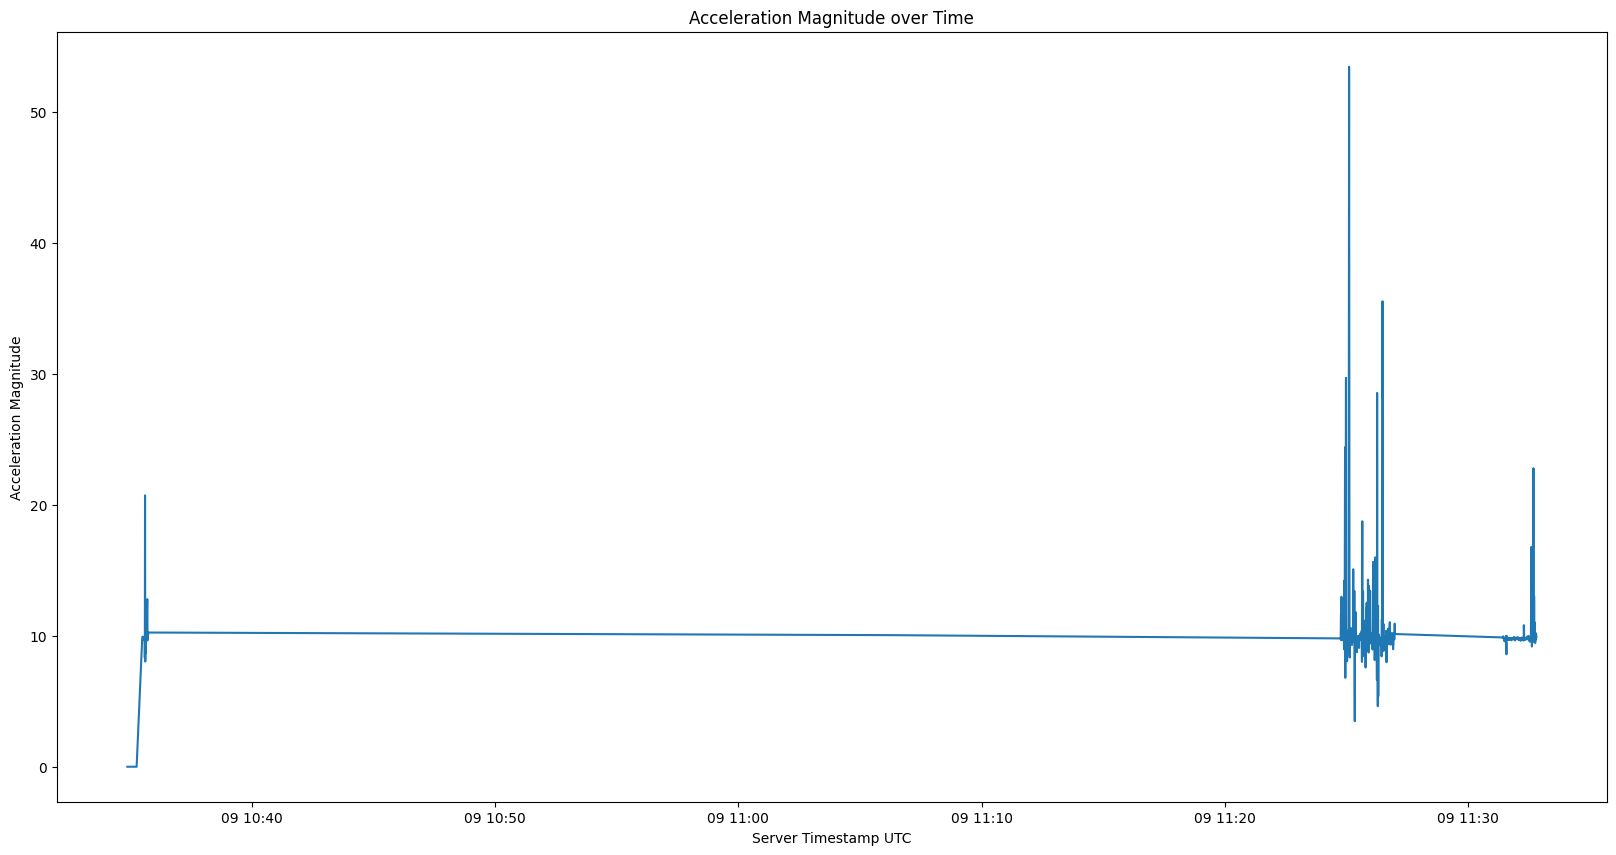

In [11]:
plt.figure(figsize=(20,10))
plt.plot(df['server_timestamp_utc'], df['acc_mag'])
plt.title('Acceleration Magnitude over Time')
plt.xlabel('Server Timestamp UTC')
plt.ylabel('Acceleration Magnitude')
plt.show()

In [12]:
print(f"Min acc_mag: {df['acc_mag'].min()}")
print(f"Max acc_mag: {df['acc_mag'].max()}")
print(f"Mean acc_mag: {df['acc_mag'].mean()}")

Min acc_mag: 0.0
Max acc_mag: 53.47599083638953
Mean acc_mag: 10.362314715148132


## Threshold Tuning Recommendations

Based on the sensor data analysis:

- **Acceleration Magnitude Statistics**:
  - Min: 0.0 m/s²
  - Max: 53.48 m/s²
  - Mean: 10.36 m/s²

- **Current Thresholds** (from app.py):
  - Freefall: 5.0 m/s²
  - Impact: 15.0 m/s²
  - Gyro Impact: 0.5 rad/s

- **Observations**:
  - The minimum acceleration in the data is 0.0 m/s², which is below the freefall threshold of 5.0 m/s², indicating potential freefall detection.
  - The maximum acceleration is 53.48 m/s², which is well above the impact threshold of 15.0 m/s².
  - Gyroscope magnitude in data is around 0.5 rad/s, so threshold adjusted to 0.5.

- **Recommendations**:
  - Thresholds have been adjusted.
  - Test fall detection by simulating a fall (e.g., drop the phone) while the app is running.

# Research: Gait Analysis

The current fall detection uses simple thresholds on acceleration magnitude. For physiotherapy, gait analysis is needed, which involves more advanced algorithms.

## 1. Cadence (Steps per Minute)

Cadence measures steps per minute. Since walking creates periodic patterns in acceleration, we can use Fast Fourier Transform (FFT) to find the dominant frequency.

### How to Calculate Cadence:
- Apply FFT to the `acc_mag` signal to get frequency components.
- The dominant frequency corresponds to the step frequency.
- Cadence = dominant_frequency * 60 (steps per minute).

### Implementation:
We'll need `numpy` and `scipy` for FFT.